In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
# import sys
# sys.path.insert(0,'../')
import utils
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional, TimeDistributed, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential

import random
import tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import time as time0
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix


# import sys
# sys.modules.pop('utils')
# import utils
plt.rcParams.update({'font.size': 20})
max_words = 50000

In [3]:
# Load the data
def load_data(path):
    # Load data
    full_data = pd.read_csv(path, header=0)

    # # Set as categorical
    full_data.iloc[:,7] = pd.Categorical(full_data.iloc[:,7])

    x_train, y_train = full_data.iloc[:,1:-1], full_data.iloc[:,-1]

    # Split data
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=3000, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

    print('\nx shape   y shape')
    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    print(x_test.shape, y_test.shape)

    # reset indices
    x_train = x_train.reset_index(drop=True)
    x_val = x_val.reset_index(drop=True)
    x_test = x_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    return x_train, y_train, x_val, y_val, x_test, y_test
    
def find_max_list(list):
    list_len = [len(i) for i in list]
    return max(list_len)
    
def lower_and_seperate(x):
    copy = x.copy()
    for number, t in enumerate(copy):
        # t = re.sub(r"[^a-z0-9#@\*'\":\-\n%,\.;\?!]+", " ", str(t).lower())  # v3 (remove ? ! from v2)
        # t = re.sub(r"#", " # ", t)
        # t = re.sub(r"@", " @ ", t)
        # t = re.sub(r"\*", " * ", t)
        # t = re.sub(r"\'", " ' ", t)
        # t = re.sub(r"\"", " \" ", t)
        # t = re.sub(r"\:", " : ", t)
        # t = re.sub(r"\-", " - ", t)
        # t = re.sub(r"\%", " % ", t)
        # t = re.sub(r"\,", " , ", t)
        # t = re.sub(r"\.", " . ", t)
        # t = re.sub(r"\;", " ; ", t)
        # t = re.sub(r"\?", " \? ", t)
        # t = re.sub(r"!", " ! ", t)

        t = re.sub(r"[^a-z0-9#@\*'\":\-\n%,\.;]+", " ", str(t).lower())  # still v2
        t = re.sub(r"#", " # ", t)
        t = re.sub(r"@", " @ ", t)
        t = re.sub(r"\*", " * ", t)
        t = re.sub(r"\'", " ' ", t)
        t = re.sub(r"\"", " \" ", t)
        t = re.sub(r"\:", " : ", t)
        t = re.sub(r"\-", " - ", t)
        t = re.sub(r"\%", " % ", t)
        t = re.sub(r"\,", " , ", t)
        t = re.sub(r"\.", " . ", t)
        t = re.sub(r"\;", " ; ", t)
        copy.iloc[number] = t
    return copy

def tokenise(x_train, x_val, x_test, char_level = False):
    x_train_las = lower_and_seperate(x_train)
    x_val_las = lower_and_seperate(x_val)
    x_test_las = lower_and_seperate(x_test)

    tokenizer = Tokenizer(num_words=50000, 
                # filters='!$&()+/<=>?[\\]^_`{|}~\t\n',  #v2
                filters='$&()+/<=>[\\]^_`{|}~\t\n',  #v3
                char_level=char_level)
    tokenizer.fit_on_texts(x_train_las)

    train_sequences = []
    for seq in tokenizer.texts_to_sequences_generator(x_train_las):
        train_sequences.append(seq)

    val_sequences = []
    for seq in tokenizer.texts_to_sequences_generator(x_val_las):
        val_sequences.append(seq)

    test_sequences = []
    for seq in tokenizer.texts_to_sequences_generator(x_test_las):
        test_sequences.append(seq)
        

    max_length = max(find_max_list(train_sequences), 
                    find_max_list(val_sequences),
                    find_max_list(test_sequences))

    x_train_tokenised = np.array(pad_sequences(train_sequences, maxlen=max_length, padding='post'))
    x_val_tokenised = np.array(pad_sequences(val_sequences, maxlen=max_length, padding='post'))
    x_test_tokenised = np.array(pad_sequences(test_sequences, maxlen=max_length, padding='post'))

    return x_train_tokenised, x_val_tokenised, x_test_tokenised, \
            x_train_las, x_val_las, x_test_las, max_length, tokenizer

def transform_to_float(y_train, y_val, y_test):
    y_train_int = (y_train == 'Spam') * 1
    y_val_int = (y_val == 'Spam')  * 1
    y_test_int = (y_test == 'Spam') * 1

    y_train_int = tensorflow.cast(y_train_int, tensorflow.float32)
    y_val_int = tensorflow.cast(y_val_int, tensorflow.float32)
    y_test_int = tensorflow.cast(y_test_int, tensorflow.float32)

    return y_train_int, y_val_int, y_test_int

def eval_model(model, x_train, y_train, x_test, y_test):
    print("Training time: {:0.3f} s".format(time9-time8))

    start_time = time0.time()
    pred = model.predict(x_test)
    end_time = time0.time()
    print("Inference time: {:0.3f} s".format(end_time-start_time))
    
    test_accuracy = model.evaluate(x_test, y_test, verbose=1)[1]
    print("Testing Accuracy: {:0.3f}".format(test_accuracy))

    # Confusion matrix
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(1, 2, 1)
    pred = (model.predict(x_train) >= 0.5) * 1   
    cm = confusion_matrix(y_train, pred)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax=ax)
    ax.set_title('Training Set Performance');

    ax = fig.add_subplot(1, 2, 2)
    pred = (model.predict(x_test) >= 0.5) * 1   
    cm = confusion_matrix(y_test, pred)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax=ax)
    ax.set_title('Testing Set Performance');
    plt.savefig(filename+"_confusion_matrix")

    # Record results
    file = open('figures/model_record.txt', 'a')
    file.write('Model ' + model_number + '\n')
    file.write('Number of Epochs used: ' + str(epoch_used) + '\n')
    file.write("Training time: {:0.3f} s\n".format(time9-time8))
    file.write("Inference time: {:0.3f} s\n".format(end_time - start_time))
    file.write("Testing Accuracy: {:0.3f}\n".format(test_accuracy))
    file.write("Classification report:\n{0}\n\n".format(classification_report(y_test_int, pred)))
    file.close()

def plot_history(history):
    fig = plt.figure(figsize=[20, 20])
    
    # TRAIN and VALIDATION LOSS
    ax = fig.add_subplot(2, 1, 1)
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value')
    ax.legend()
    ax.set_title('Loss vs Epoch')

    # TRAIN and VALIDATION ACCURACY
    ax = fig.add_subplot(2, 1, 2)
    plt.plot(history['accuracy'], label='train_accuracy')
    plt.plot(history['val_accuracy'], label='val_accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value')
    ax.legend()
    ax.set_title('Accuracy vs Epoch')
    
    plt.savefig(filename+'_history')

In [4]:
# Load data
x_train, y_train, x_val, y_val, x_test, y_test = utils.load_data('../train.csv')

print('\nx shape   y shape')
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

x_traincopy = x_train.copy()
x_valcopy = x_val.copy()
x_testcopy = x_test.copy()

# Tokenise tweet and convert to Tensor shape
x_train_tweet, x_val_tweet, x_test_tweet, \
x_train_las, x_val_las, x_test_las, \
max_length, tokenizer = tokenise(x_traincopy.iloc[:,0], x_valcopy.iloc[:,0], x_testcopy.iloc[:,0])

x_train_tweet = np.array(x_train_tweet.reshape(x_train_tweet.shape[0], max_length, 1))
x_val_tweet = np.array(x_val_tweet.reshape(x_val_tweet.shape[0], max_length, 1))
x_test_tweet = np.array(x_test_tweet.reshape(x_test_tweet.shape[0], max_length, 1))

print(x_train_tweet.shape)
print(x_val_tweet.shape)
print(x_test_tweet.shape)


#############################################
y_train_int, y_val_int, y_test_int = \
    transform_to_float(y_train.copy(), y_val.copy(), y_test.copy())


x shape   y shape
(8968, 6) (8968,)
(1500, 6) (1500,)
(1500, 6) (1500,)

x shape   y shape
(8968, 6) (8968,)
(1500, 6) (1500,)
(1500, 6) (1500,)


error: nothing to repeat at position 0

In [4]:
# # Load data
# x_train, y_train, x_val, y_val, x_test, y_test = load_data('../train.csv')

# # Clean data, remove nan, 
# x_train["location"] = x_train.location.fillna("")
# cols = ['following', 'followers', 'actions']
# x_train_imp, imputer = utils.impute_dataframe(x_train, cols, verbose=True)
# x_train_imp = x_train_imp.dropna()

# x_val["location"] = x_val.location.fillna("")
# x_val_imp_intermediate = pd.DataFrame(imputer.transform(x_val[cols]), columns=imputer.feature_names_in_, index=x_val.index)
# x_val_imp = x_val.copy()
# x_val_imp[cols] = x_val_imp_intermediate[cols]
# print(x_val_imp.shape)
# print(True in x_val_imp.isna())

# x_test["location"] = x_test.location.fillna("")
# x_test_imp_intermediate = pd.DataFrame(imputer.transform(x_test[cols]), columns=imputer.feature_names_in_, index=x_test.index)
# x_test_imp = x_test.copy()
# x_test_imp[cols] = x_test_imp_intermediate[cols]
# print(x_test_imp.shape)
# print(True in x_test_imp.isna())


# # Remove the same rows containing nan in y as well
# y_train = y_train[y_train.index.intersection(x_train_imp.index)]
# y_val = y_val[y_val.index.intersection(x_val_imp.index)]
# y_test = y_test[y_test.index.intersection(x_test_imp.index)]

# # Tokenise tweet and convert to Tensor shape
# x_traincopy = x_train_imp.copy()
# x_valcopy = x_val_imp.copy()
# x_testcopy = x_test_imp.copy()

# x_train_tweet, x_val_tweet, x_test_tweet, \
# x_train_las, x_val_las, x_test_las, \
# max_length, tokenizer = tokenise(x_traincopy.loc[:,'Tweet'], x_valcopy.iloc[:,0], x_testcopy.iloc[:,0])

# # Reshape input for our model's demand
# x_train_tweet = np.array(x_train_tweet.reshape(x_train_tweet.shape[0], max_length, 1))
# x_val_tweet = np.array(x_val_tweet.reshape(x_val_tweet.shape[0], max_length, 1))
# x_test_tweet = np.array(x_test_tweet.reshape(x_test_tweet.shape[0], max_length, 1))

# # Transform y for compatability
# y_train_int, y_val_int, y_test_int = \
#     transform_to_float(y_train.copy(), y_val.copy(), y_test.copy())

In [7]:
batch_size = 128
model_number = '00_experiement_1lstm'

# Model 3  Less LSTM
inputA = Input(shape = (max_length,1), name = 'tokenised_tweets')
# x = LSTM(128, return_sequences=True)(inputA)
# x = LSTM(64)(x)
x = LSTM(128)(inputA)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)
lstm_model = Model(inputA, output)

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# lstm_model.summary()

In [8]:
filename = f"figures/model_{model_number}_{random.randint(1000,9999)}"
modelfilename = filename+'.h5'
history_filename = filename+'_history'

checkpoint = ModelCheckpoint(modelfilename, verbose=1, monitor='val_loss', save_best_only=True, mode='auto')
earlystopping = EarlyStopping(monitor='val_loss', patience=25)

time8 = time0.time()
history = lstm_model.fit(x_train_tweet, y_train_int,
            batch_size=batch_size,
            epochs=300,
            validation_data=(x_val_tweet, y_val_int),
            callbacks=[earlystopping, checkpoint])
time9 = time0.time()

lstm_model.load_weights(modelfilename)
utils.savedata(history.history, history_filename)
epoch_used = len(history.history['val_accuracy'])
print("Best val_loss model loaded!")

Epoch 1/300
71/71 [==============================] - 14s 172ms/step - loss: 0.6929 - accuracy: 0.5174 - val_loss: 0.6929 - val_accuracy: 0.5060

Epoch 00001: val_loss improved from inf to 0.69293, saving model to figures\model_00_experiement_1lstm_9123.h5
Epoch 2/300
71/71 [==============================] - 12s 163ms/step - loss: 0.6926 - accuracy: 0.5184 - val_loss: 0.6929 - val_accuracy: 0.5060

Epoch 00002: val_loss improved from 0.69293 to 0.69291, saving model to figures\model_00_experiement_1lstm_9123.h5
Epoch 3/300
71/71 [==============================] - 13s 179ms/step - loss: 0.6927 - accuracy: 0.5183 - val_loss: 0.6933 - val_accuracy: 0.5060

Epoch 00003: val_loss did not improve from 0.69291
Epoch 4/300
71/71 [==============================] - 12s 171ms/step - loss: 0.6927 - accuracy: 0.5184 - val_loss: 0.6931 - val_accuracy: 0.5060

Epoch 00004: val_loss did not improve from 0.69291
Epoch 5/300
71/71 [==============================] - 12s 169ms/step - loss: 0.6927 - accurac

Training time: 812.810 s
Inference time: 1.798 s
47/47 [==============================] - 1s 28ms/step - loss: 0.2082 - accuracy: 0.9273
Testing Accuracy: 0.9273333549499512
47/47 - 1s - loss: 0.2082 - accuracy: 0.9273
Test accuracy: 0.9273333549499512


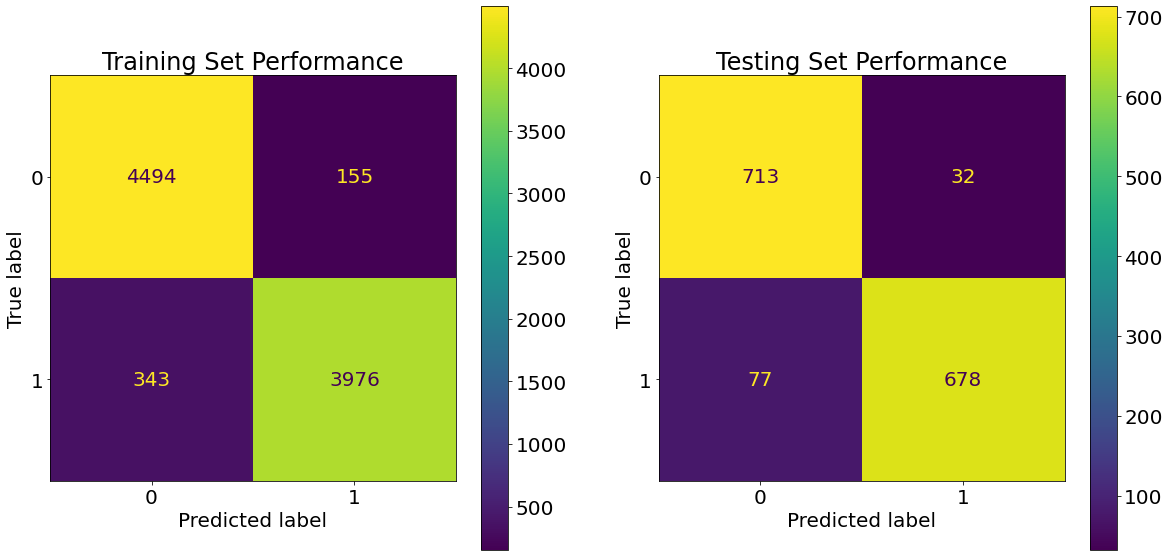

In [9]:
def eval_model(model, x_train, y_train, x_test, y_test):
    
    print("Training time: {:0.3f} s".format(time9-time8))

    start_time = time0.time()
    pred = model.predict(x_test)
    end_time = time0.time()
    print("Inference time: {:0.3f} s".format(end_time-start_time))
    
    test_accuracy = lstm_model.evaluate(x_test, y_test, verbose=1)[1]
    print('Testing Accuracy:', test_accuracy)

    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test accuracy:', test_scores[1])

    # Confusion matrix
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(1, 2, 1)
    pred = (model.predict(x_train) >= 0.5) * 1   
    cm = confusion_matrix(y_train, pred)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax=ax)
    ax.set_title('Training Set Performance');

    ax = fig.add_subplot(1, 2, 2)
    pred = (model.predict(x_test) >= 0.5) * 1   
    cm = confusion_matrix(y_test, pred)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax=ax)
    ax.set_title('Testing Set Performance');
    plt.savefig(filename+"_confusion_matrix")


    file = open('figures/model_record.txt', 'a')
    file.write('Model ' + model_number + '\n')
    file.write('Number of Epochs used: ' + str(epoch_used) + '\n')
    file.write("Training time: {:0.3f} s\n".format(time9-time8))
    file.write("Inference time: {:0.3f} s\n".format(end_time - start_time))
    file.write("Testing Accuracy: {:0.3f}\n".format(test_accuracy))
    file.write("Classification report:\n{0}\n\n".format(classification_report(y_test_int, pred)))
    file.close()


# time9 = time8 = epoch_used = 0
# lstm_model.load_weights('figures/model_03_v2_keep_more_chars_923.h5')

eval_model(lstm_model, x_train_tweet, y_train_int, x_test_tweet, y_test_int)

In [10]:
# Save pred, tokenizer
pred = (lstm_model.predict(x_test_tweet) >= 0.5) * 1  
utils.savedata(pred, filename+'_pred_test')

pred = (lstm_model.predict(x_train_tweet) >= 0.5) * 1  
utils.savedata(pred, filename+'_pred_train')

utils.savedata(tokenizer, filename+'_tokenizer')

In [11]:
pred = (lstm_model.predict(x_test_tweet) >= 0.5) * 1
print(pred[10:20])
print(y_test_int[10:20])

[[1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]]
tf.Tensor([1. 0. 0. 1. 0. 1. 1. 1. 1. 1.], shape=(10,), dtype=float32)


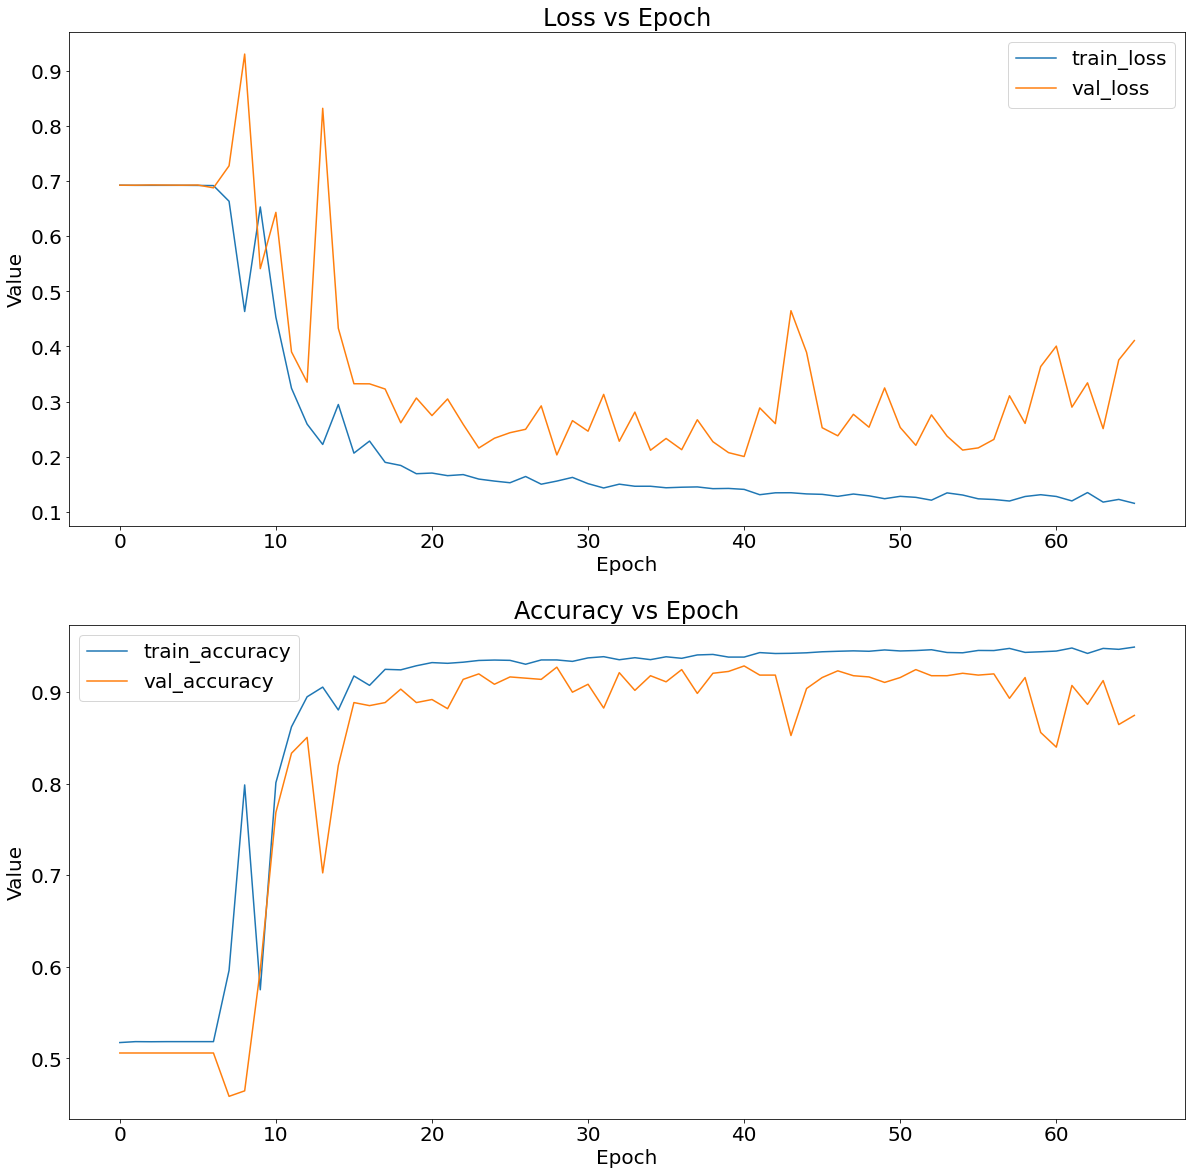

In [12]:
def plot_history(history):
    fig = plt.figure(figsize=[20, 20])
    
    # TRAIN and VALIDATION LOSS
    ax = fig.add_subplot(2, 1, 1)
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value')
    ax.legend()
    ax.set_title('Loss vs Epoch')

    # TRAIN and VALIDATION ACCURACY
    ax = fig.add_subplot(2, 1, 2)
    plt.plot(history['accuracy'], label='train_accuracy')
    plt.plot(history['val_accuracy'], label='val_accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value')
    ax.legend()
    ax.set_title('Accuracy vs Epoch')
    
    plt.savefig(history_filename)


# history_filename = "figures/model_03_v2_keep_more_chars_923_history"
# history = utils.loaddata(history_filename)
plot_history(history.history)

In [13]:

# Style 1
# lstm_model = Sequential()
# lstm_model.add(Embedding(50000, batch_size, input_length=max_length))
# lstm_model.add(LSTM(64))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(32, activation='relu'))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(1, activation='sigmoid'))

# lstm_model = Sequential([
#     Input(shape = (max_length,1), name = 'tokenised_tweets'),
#     LSTM(64),
#     Dropout(0.2),
#     Dense(32, activation='relu'),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')
# ])

# Style 2
# input = Input(shape = (max_length,1), name = 'tokenised_tweets')
# x = LSTM(64)(input)
# x = Dropout(0.2)(x)
# x = Dense(32, activation='relu')(x)
# x = Dropout(0.2)(x)
# output = Dense(1, activation='sigmoid')(x)
# lstm_model = Model(input, output)


# Model 2
#### input = Embedding(max_words, 128, input_length=max_length)
# input = Input(shape = (max_length,1), name = 'tokenised_tweets')
# x = LSTM(128, return_sequences=True)(input)
# x = LSTM(64, return_sequences=True)(x)
# x = LSTM(32)(x)
# x = Dropout(0.2)(x)
# x = Dense(32, activation='relu')(x)
# x = Dropout(0.2)(x)
# output = Dense(1, activation='sigmoid')(x)
# lstm_model = Model(input, output)